In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(themis)
options(repr.matrix.max.rows = 9)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        1.0.0      ✔ tune         0.2.0 
✔ infer        1.0.2      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      1.0.0      ✔ yardstick    1.0.0 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filte

In [2]:
set.seed(2022) #we need this to make our code reproducible, since sample is a random function

weather_data <- read_csv("https://raw.githubusercontent.com/hyunseokjg/DSCI100-Group15-Project/main/data/testing_set.csv")
weather_data

#Let's remove the very rare weather classes for simplicity and so we do not overreppresent them when we balance our data

filtered_weather_data <- weather_data %>%
    filter(Weather != "Heavy Rain", 
           Weather != "Moderate Rain",
           Weather != "Clear",
           Weather != "Moderate Rain,Fog") %>%
    mutate(Weather = as_factor(Weather)) %>%
    sample_n(500)
filtered_weather_data

#Now we can split our dataset into training and testing sets using the initial_split function so we don't create our model with the same
#data that we will use to test it later on.

weather_split <- initial_split(filtered_weather_data, prop = 0.75, strata = Weather)
weather_train = training(weather_split)
weather_test = testing(weather_split)

Rows: 3914 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Weather
dbl (5): Temp, Humid, Wind_Spd, Vis, Press

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
12.8,100,4,32.2,101.78,Mostly Cloudy
10.4,100,4,32.2,101.72,Mostly Cloudy
15.3,80,3,48.3,101.72,Mostly Cloudy
16.8,85,19,48.3,101.65,Mostly Cloudy
17.2,84,18,48.3,101.54,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
15.7,81,12,32.2,102.19,Cloudy
17.3,72,9,48.3,102.19,Mostly Cloudy
16.4,69,15,32.2,102.14,Mainly Clear


Temp,Humid,Wind_Spd,Vis,Press,Weather
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15.9,81,18,48.3,100.73,Rain Showers
12.0,84,28,32.2,101.89,Mostly Cloudy
15.3,96,21,24.1,100.54,Rain
15.6,77,16,48.3,101.49,Mostly Cloudy
19.0,74,11,48.3,101.18,Cloudy
⋮,⋮,⋮,⋮,⋮,⋮
13.1,83,8,32.2,102.08,Mainly Clear
18.6,79,18,48.3,100.48,Mostly Cloudy
18.6,79,18,48.3,100.48,Mostly Cloudy


In [3]:
#check to see if proportions of data are close enough to use or if we should scale up some
#of the other weather classifications

number_rows <- nrow(weather_train)

proportions <- weather_train %>%
    group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)
proportions

Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,112,29.946524
Cloudy,85,22.727273
Rain Showers,34,9.090909
Rain,99,26.470588
Mainly Clear,44,11.764706


In [4]:
#now because we can see our classes are unbalanced, we want to balance our classes using scale_upsample
ups_recipe <- recipe(Weather ~ ., data = weather_train) %>%
    step_upsample(Weather, over_ratio = 1, skip = FALSE) %>%
    prep()

#now we create our new data set with balanced classes
upsampled_weather <- bake(ups_recipe, weather_train)

#now we check weather our classes have been properly balanced
upsampled_weather %>% group_by(Weather) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/number_rows)

Weather,n,percent
<fct>,<int>,<dbl>
Mostly Cloudy,112,29.94652
Cloudy,112,29.94652
Rain Showers,112,29.94652
Rain,112,29.94652
Mainly Clear,112,29.94652


In [5]:
#now we will create the functions we will use many times later in forward selection and our final model. 
weather_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

weather_vfold <- vfold_cv(weather_train, v = 5, strata = Weather)

k_grid <- tibble(neighbors = 1:30)

# Forward Selection - Predictor Variable Selection Process

#### Phase 1: One Variable

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4435204,5,0.012553646,Preprocessor1_Model01
3,accuracy,multiclass,0.4433818,5,0.024008899,Preprocessor1_Model03
2,accuracy,multiclass,0.4250173,5,0.009343053,Preprocessor1_Model02
5,accuracy,multiclass,0.4218988,5,0.028918272,Preprocessor1_Model05
4,accuracy,multiclass,0.4140679,5,0.028701233,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21,accuracy,multiclass,0.3528760,5,0.011408547,Preprocessor1_Model21
10,accuracy,multiclass,0.3501733,5,0.009205178,Preprocessor1_Model10
12,accuracy,multiclass,0.3500347,5,0.016616995,Preprocessor1_Model12


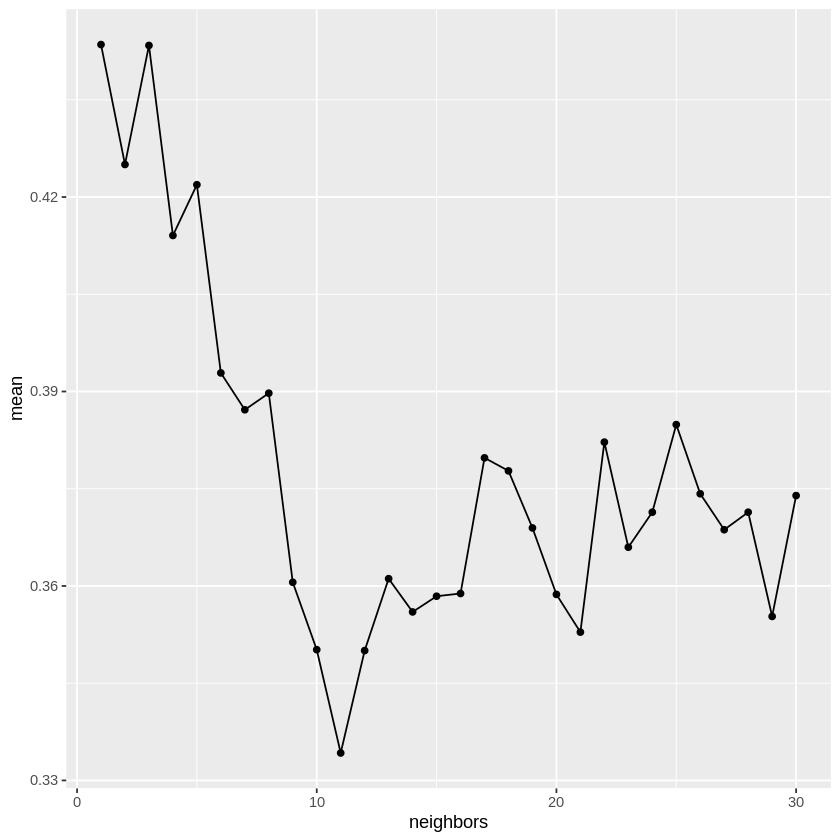

In [14]:
# Model 1.1 - Temperature
temp_recipe <- recipe(Weather ~ Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp_fit <- workflow() %>%
    add_recipe(temp_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp_accuracy <- temp_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp_accuracy

temp_accuracy_plot <- temp_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
18,accuracy,multiclass,0.4617464,5,0.02582360,Preprocessor1_Model18
19,accuracy,multiclass,0.4510742,5,0.02180239,Preprocessor1_Model19
17,accuracy,multiclass,0.4507970,5,0.02704657,Preprocessor1_Model17
21,accuracy,multiclass,0.4462231,5,0.01430732,Preprocessor1_Model21
25,accuracy,multiclass,0.4462231,5,0.01772762,Preprocessor1_Model25
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,multiclass,0.3447678,5,0.020073707,Preprocessor1_Model06
5,accuracy,multiclass,0.3369369,5,0.023810046,Preprocessor1_Model05
9,accuracy,multiclass,0.3365211,5,0.017944704,Preprocessor1_Model09


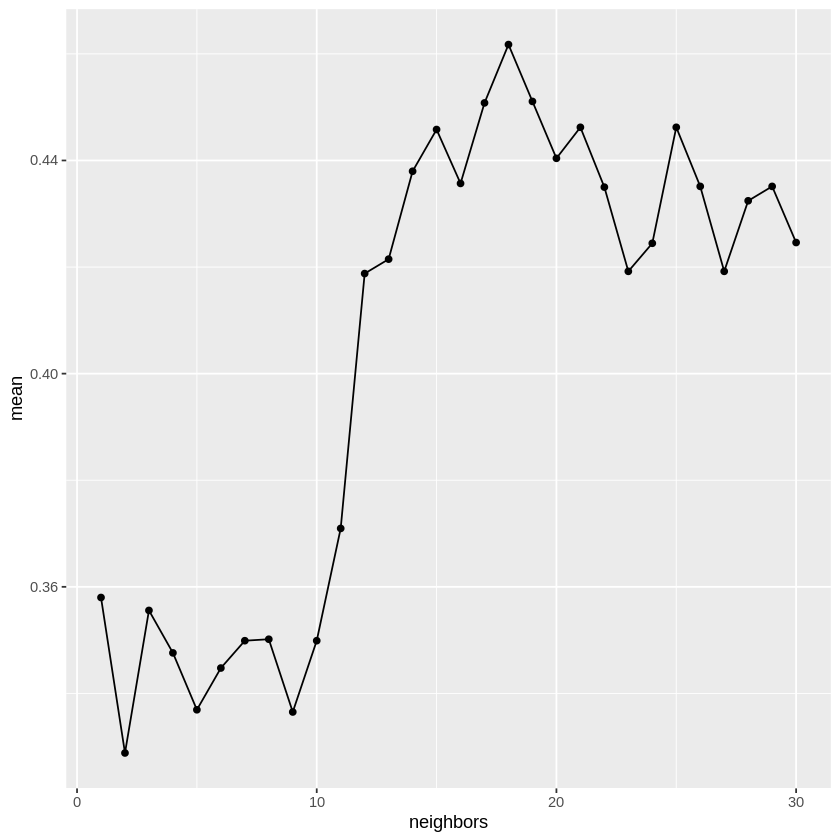

In [15]:
# Model 2.1 - Humidity
humid_recipe <- recipe(Weather ~ Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid_fit <- workflow() %>%
    add_recipe(humid_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid_accuracy <- humid_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
humid_accuracy

humid_accuracy_plot <- humid_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
humid_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,multiclass,0.3796258,5,0.02494889,Preprocessor1_Model10
12,accuracy,multiclass,0.3796258,5,0.02223998,Preprocessor1_Model12
8,accuracy,multiclass,0.3774775,5,0.03472853,Preprocessor1_Model08
9,accuracy,multiclass,0.3774775,5,0.02962033,Preprocessor1_Model09
11,accuracy,multiclass,0.3769231,5,0.02203056,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,accuracy,multiclass,0.3376299,5,0.03375322,Preprocessor1_Model27
23,accuracy,multiclass,0.3353430,5,0.03544622,Preprocessor1_Model23
24,accuracy,multiclass,0.3353430,5,0.04311687,Preprocessor1_Model24


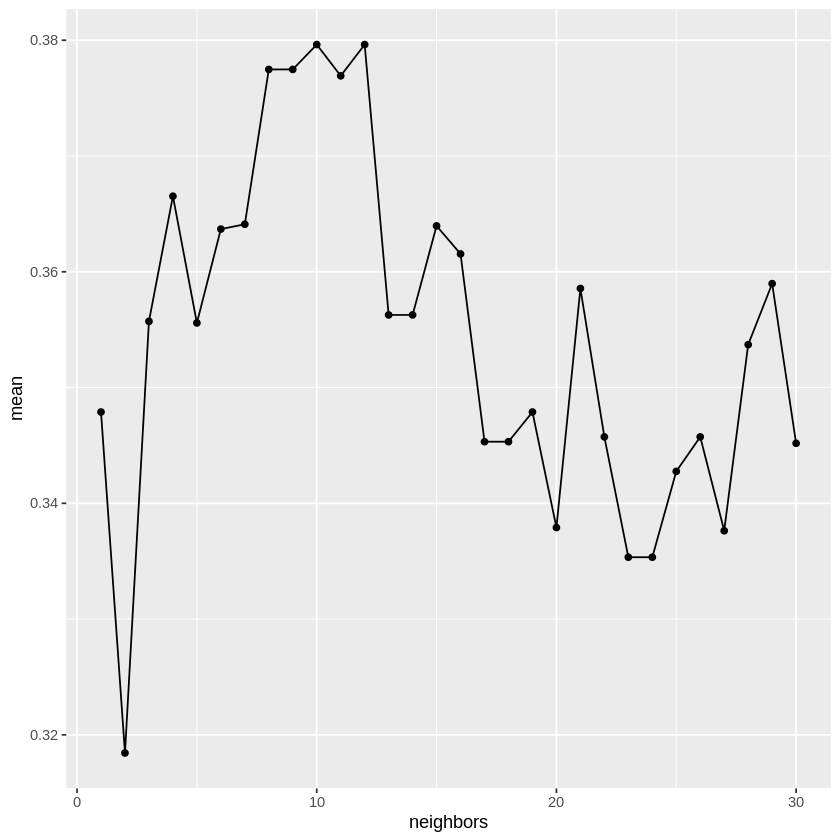

In [16]:
# Model 3.1 - Wind Speed
wind_recipe <- recipe(Weather ~ Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind_fit <- workflow() %>%
    add_recipe(wind_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind_accuracy <- wind_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind_accuracy

wind_accuracy_plot <- wind_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
12,accuracy,multiclass,0.3107415,5,0.02054002,Preprocessor1_Model12
13,accuracy,multiclass,0.3107415,5,0.02054002,Preprocessor1_Model13
14,accuracy,multiclass,0.3107415,5,0.02054002,Preprocessor1_Model14
15,accuracy,multiclass,0.3107415,5,0.02054002,Preprocessor1_Model15
16,accuracy,multiclass,0.3107415,5,0.02054002,Preprocessor1_Model16
⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,accuracy,multiclass,0.2599446,5,0.01942331,Preprocessor1_Model07
4,accuracy,multiclass,0.2573805,5,0.02412359,Preprocessor1_Model04
5,accuracy,multiclass,0.2437283,5,0.01168308,Preprocessor1_Model05


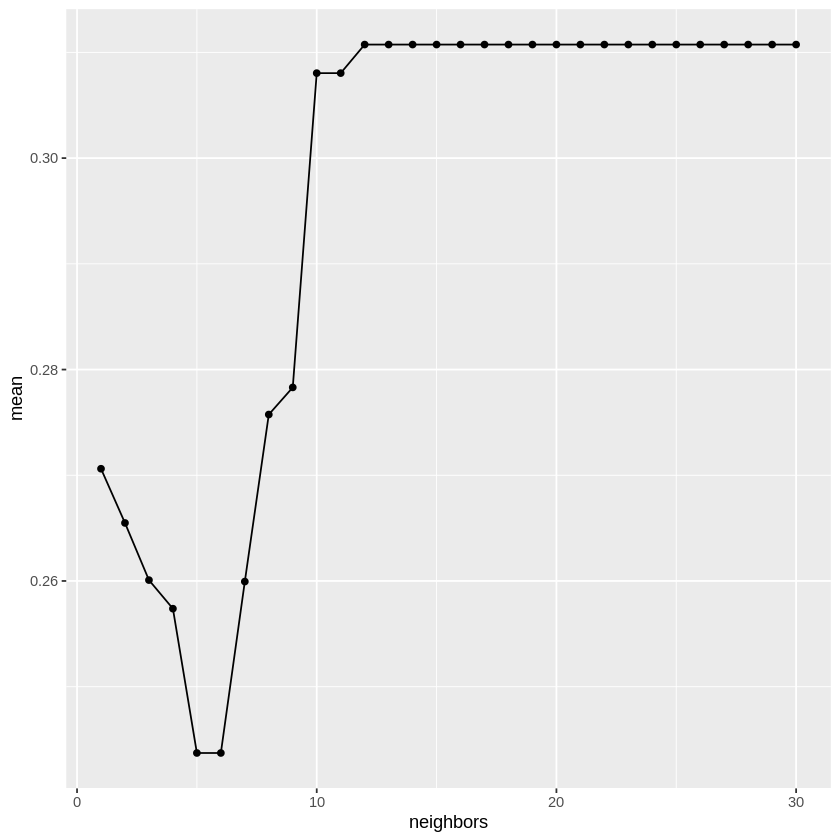

In [17]:
# Model 4.1 - Visability
vis_recipe <- recipe(Weather ~ Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis_fit <- workflow() %>%
    add_recipe(vis_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis_accuracy <- vis_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis_accuracy

vis_accuracy_plot <- vis_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
vis_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.6738739,5,0.01144889,Preprocessor1_Model02
1,accuracy,multiclass,0.6710326,5,0.01263686,Preprocessor1_Model01
3,accuracy,multiclass,0.6257796,5,0.01035335,Preprocessor1_Model03
4,accuracy,multiclass,0.6048510,5,0.01872308,Preprocessor1_Model04
6,accuracy,multiclass,0.5506584,5,0.02740233,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.4157311,5,0.03893027,Preprocessor1_Model18
19,accuracy,multiclass,0.4128898,5,0.03635490,Preprocessor1_Model19
21,accuracy,multiclass,0.3995149,5,0.03309486,Preprocessor1_Model21


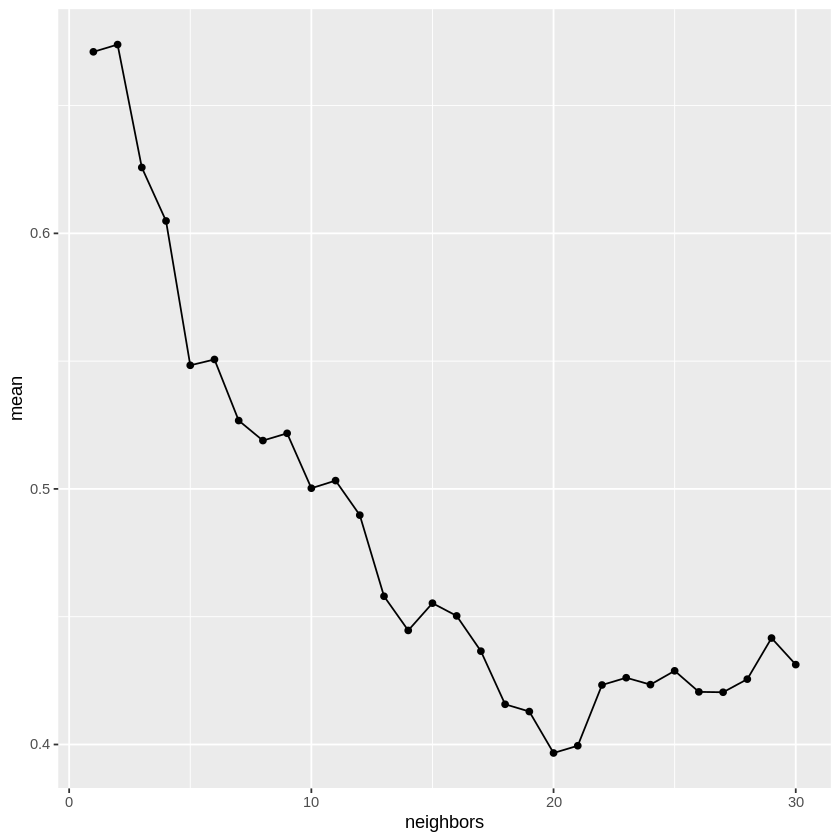

In [18]:
# Model 5.1 - Air Pressure
press_recipe <- recipe(Weather ~ Press, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

press_fit <- workflow() %>%
    add_recipe(press_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

press_accuracy <- press_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
press_accuracy

press_accuracy_plot <- press_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
press_accuracy_plot

**Findings:** Using air pressure has the highest prediction accuracy so far.

#### Phase 2: Two Predictor Variables

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8769231,5,0.01251552,Preprocessor1_Model01
2,accuracy,multiclass,0.8769231,5,0.01251552,Preprocessor1_Model02
3,accuracy,multiclass,0.7219681,5,0.02029516,Preprocessor1_Model03
4,accuracy,multiclass,0.6791407,5,0.02109814,Preprocessor1_Model04
5,accuracy,multiclass,0.5984754,5,0.02367624,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.4110880,5,0.02457677,Preprocessor1_Model18
15,accuracy,multiclass,0.4093555,5,0.02784893,Preprocessor1_Model15
14,accuracy,multiclass,0.4065142,5,0.03011333,Preprocessor1_Model14


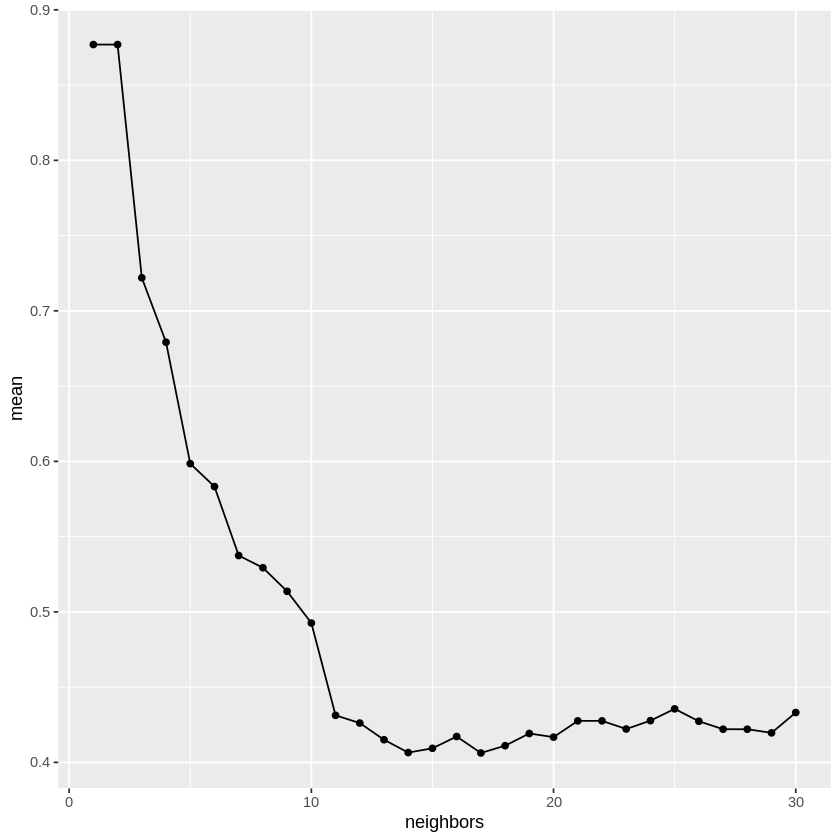

In [34]:
# Model 1.2 - Air Pressure + Temperature
temp2_recipe <- recipe(Weather ~ Press + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp2_fit <- workflow() %>%
    add_recipe(temp2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp2_accuracy <- temp2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp2_accuracy

temp2_accuracy_plot <- temp2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp2_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8793486,5,0.02292104,Preprocessor1_Model01
2,accuracy,multiclass,0.8766459,5,0.02350003,Preprocessor1_Model02
3,accuracy,multiclass,0.7030492,5,0.03025783,Preprocessor1_Model03
4,accuracy,multiclass,0.6657658,5,0.03236981,Preprocessor1_Model04
5,accuracy,multiclass,0.5830908,5,0.03718893,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
15,accuracy,multiclass,0.4652807,5,0.02618552,Preprocessor1_Model15
29,accuracy,multiclass,0.4631324,5,0.02046923,Preprocessor1_Model29
20,accuracy,multiclass,0.4629938,5,0.01166652,Preprocessor1_Model20


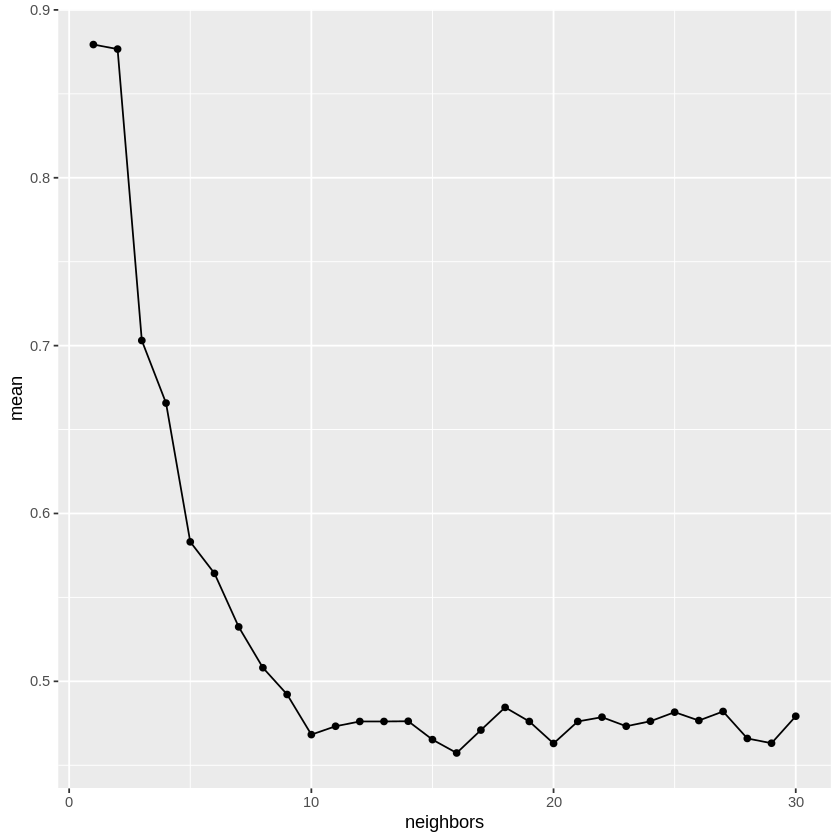

In [35]:
# Model 2.2 - Air Pressure + Humidity
humid2_recipe <- recipe(Weather ~ Press + Humid, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

humid2_fit <- workflow() %>%
    add_recipe(humid2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

humid2_accuracy <- humid2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
humid2_accuracy

humid2_accuracy_plot <- humid2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
humid2_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.8586972,5,0.01307753,Preprocessor1_Model02
1,accuracy,multiclass,0.8531532,5,0.01033094,Preprocessor1_Model01
3,accuracy,multiclass,0.6690229,5,0.02780855,Preprocessor1_Model03
4,accuracy,multiclass,0.6209286,5,0.02899962,Preprocessor1_Model04
7,accuracy,multiclass,0.5247401,5,0.02691565,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
24,accuracy,multiclass,0.2912682,5,0.02232726,Preprocessor1_Model24
27,accuracy,multiclass,0.2860014,5,0.02231543,Preprocessor1_Model27
25,accuracy,multiclass,0.2832987,5,0.02485656,Preprocessor1_Model25


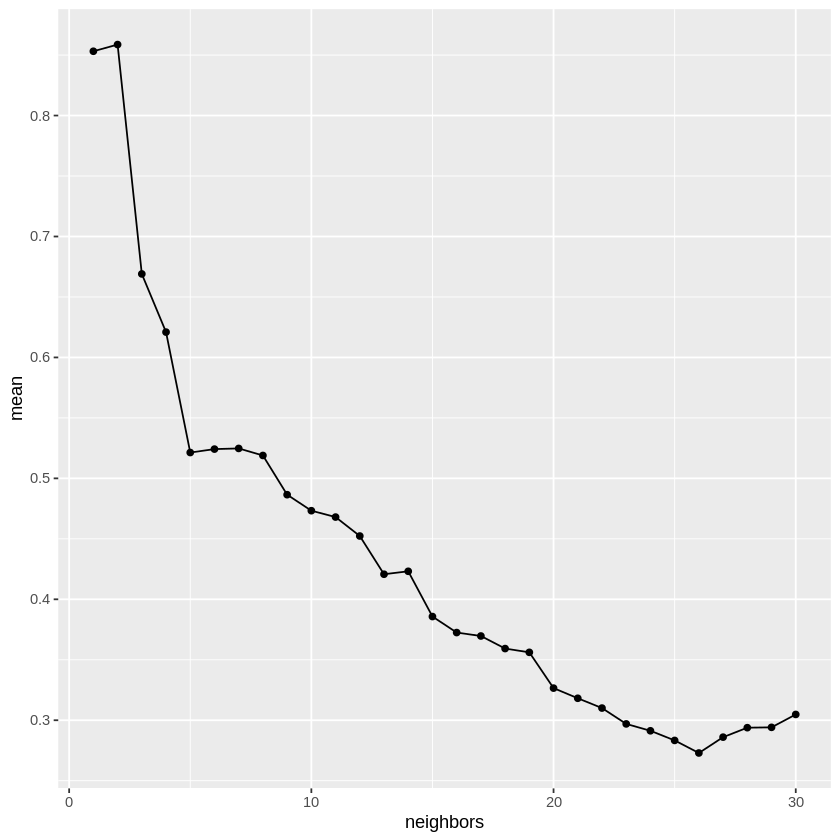

In [36]:
# Model 3.2 - Air Pressure + Wind Speed
wind2_recipe <- recipe(Weather ~ Press + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind2_fit <- workflow() %>%
    add_recipe(wind2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind2_accuracy <- wind2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind2_accuracy

wind2_accuracy_plot <- wind2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind2_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8076230,5,0.01840840,Preprocessor1_Model01
2,accuracy,multiclass,0.8050589,5,0.02557295,Preprocessor1_Model02
3,accuracy,multiclass,0.6795565,5,0.02494740,Preprocessor1_Model03
4,accuracy,multiclass,0.6661816,5,0.02489421,Preprocessor1_Model04
5,accuracy,multiclass,0.6421344,5,0.02793541,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,multiclass,0.4598753,5,0.01709845,Preprocessor1_Model23
18,accuracy,multiclass,0.4550243,5,0.02315478,Preprocessor1_Model18
22,accuracy,multiclass,0.4517672,5,0.01581819,Preprocessor1_Model22


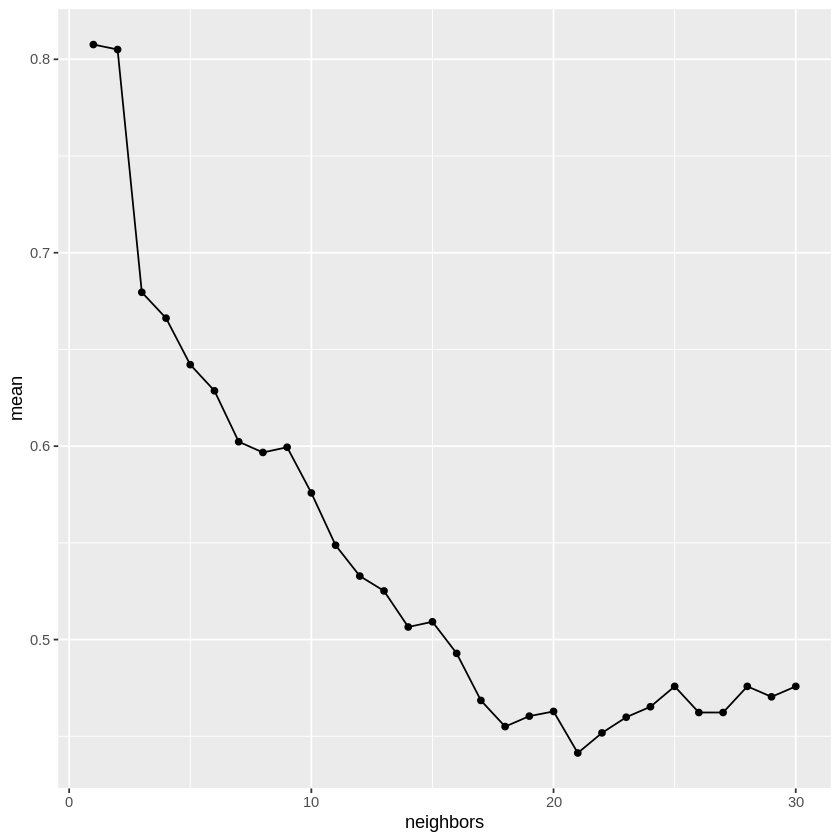

In [37]:
# Model 4.2 - Air Pressure + Visibility
vis2_recipe <- recipe(Weather ~ Press + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis2_fit <- workflow() %>%
    add_recipe(vis2_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis2_accuracy <- vis2_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis2_accuracy

vis2_accuracy_plot <- vis2_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
vis2_accuracy_plot

**Findings:** Using air pressure and humidity has the highest accuracy so far.

#### Phase 3: Three Variables

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8848926,5,0.02089727,Preprocessor1_Model01
2,accuracy,multiclass,0.8848926,5,0.02089727,Preprocessor1_Model02
3,accuracy,multiclass,0.7299376,5,0.01862825,Preprocessor1_Model03
4,accuracy,multiclass,0.7061677,5,0.02447823,Preprocessor1_Model04
5,accuracy,multiclass,0.6207900,5,0.02734974,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,accuracy,multiclass,0.4598753,5,0.02049848,Preprocessor1_Model19
18,accuracy,multiclass,0.4597367,5,0.01358547,Preprocessor1_Model18
20,accuracy,multiclass,0.4597367,5,0.01818397,Preprocessor1_Model20


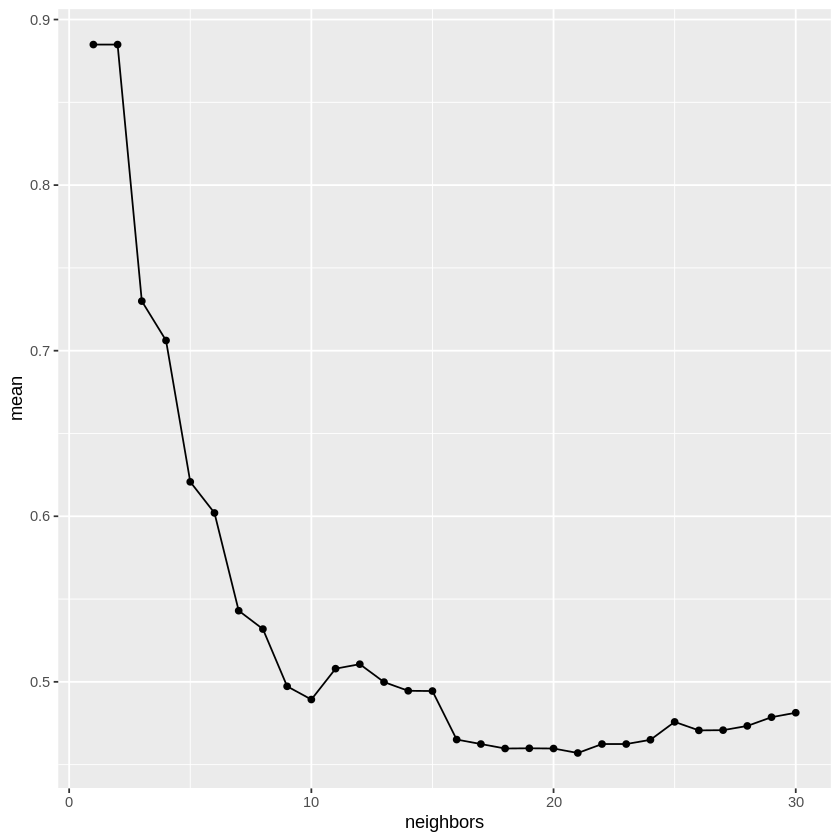

In [38]:
# Model 1.3 - Air Pressure + Humidity + Temperature
temp3_recipe <- recipe(Weather ~ Press + Humid + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp3_fit <- workflow() %>%
    add_recipe(temp3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp3_accuracy <- temp3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp3_accuracy

temp3_accuracy_plot <- temp3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp3_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8608455,5,0.01345278,Preprocessor1_Model01
2,accuracy,multiclass,0.8608455,5,0.01345278,Preprocessor1_Model02
3,accuracy,multiclass,0.6790021,5,0.03408137,Preprocessor1_Model03
4,accuracy,multiclass,0.6549550,5,0.02731082,Preprocessor1_Model04
5,accuracy,multiclass,0.6036036,5,0.03285510,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,accuracy,multiclass,0.4655579,5,0.01599564,Preprocessor1_Model22
23,accuracy,multiclass,0.4628552,5,0.01904504,Preprocessor1_Model23
25,accuracy,multiclass,0.4628552,5,0.01701962,Preprocessor1_Model25


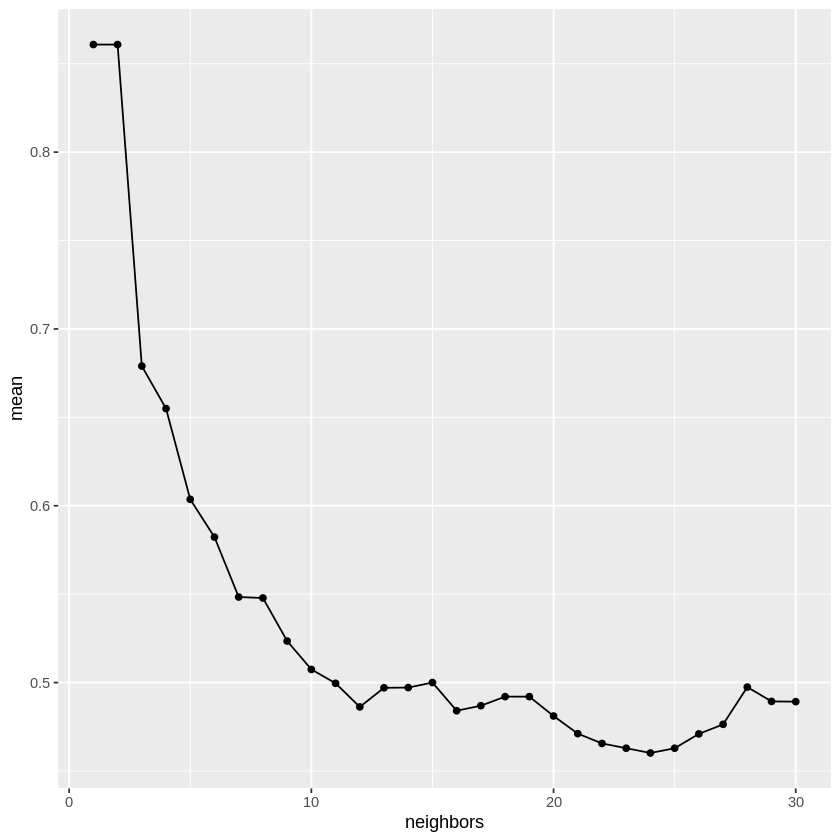

In [39]:
# Model 2.3 - Air Pressure + Humidity + Wind Speed
wind3_recipe <- recipe(Weather ~ Press + Humid + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind3_fit <- workflow() %>%
    add_recipe(wind3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind3_accuracy <- wind3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind3_accuracy

wind3_accuracy_plot <- wind3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind3_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8959806,5,0.010791358,Preprocessor1_Model01
2,accuracy,multiclass,0.8932779,5,0.011370281,Preprocessor1_Model02
3,accuracy,multiclass,0.7168399,5,0.021177777,Preprocessor1_Model03
4,accuracy,multiclass,0.6930700,5,0.020779739,Preprocessor1_Model04
5,accuracy,multiclass,0.6525295,5,0.009510409,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,multiclass,0.4813583,5,0.013200890,Preprocessor1_Model23
20,accuracy,multiclass,0.4762301,5,0.013490216,Preprocessor1_Model20
22,accuracy,multiclass,0.4731116,5,0.012857264,Preprocessor1_Model22


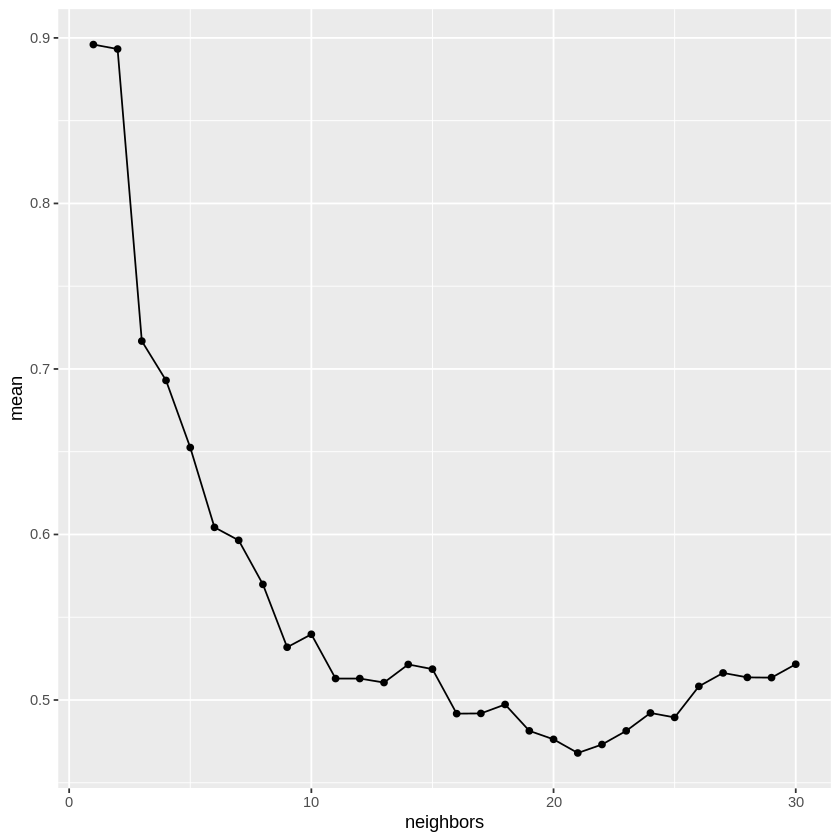

In [41]:
# Model 3.3 - Air Pressure + Humidity + Visibility
vis3_recipe <- recipe(Weather ~ Press + Humid + Vis, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

vis3_fit <- workflow() %>%
    add_recipe(vis3_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

vis3_accuracy <- vis3_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
vis3_accuracy

vis3_accuracy_plot <- vis3_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
vis3_accuracy_plot

**Findings:** Using air Pressure, humidity and visibility has the highest accuracy so far.

#### Phase 4: Four Variables

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8928621,5,0.01239309,Preprocessor1_Model01
2,accuracy,multiclass,0.8928621,5,0.01239309,Preprocessor1_Model02
3,accuracy,multiclass,0.7325017,5,0.01506061,Preprocessor1_Model03
4,accuracy,multiclass,0.7142758,5,0.01988006,Preprocessor1_Model04
5,accuracy,multiclass,0.6499653,5,0.02568299,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
30,accuracy,multiclass,0.4759529,5,0.01620703,Preprocessor1_Model30
26,accuracy,multiclass,0.4733888,5,0.01904189,Preprocessor1_Model26
25,accuracy,multiclass,0.4679834,5,0.01683350,Preprocessor1_Model25


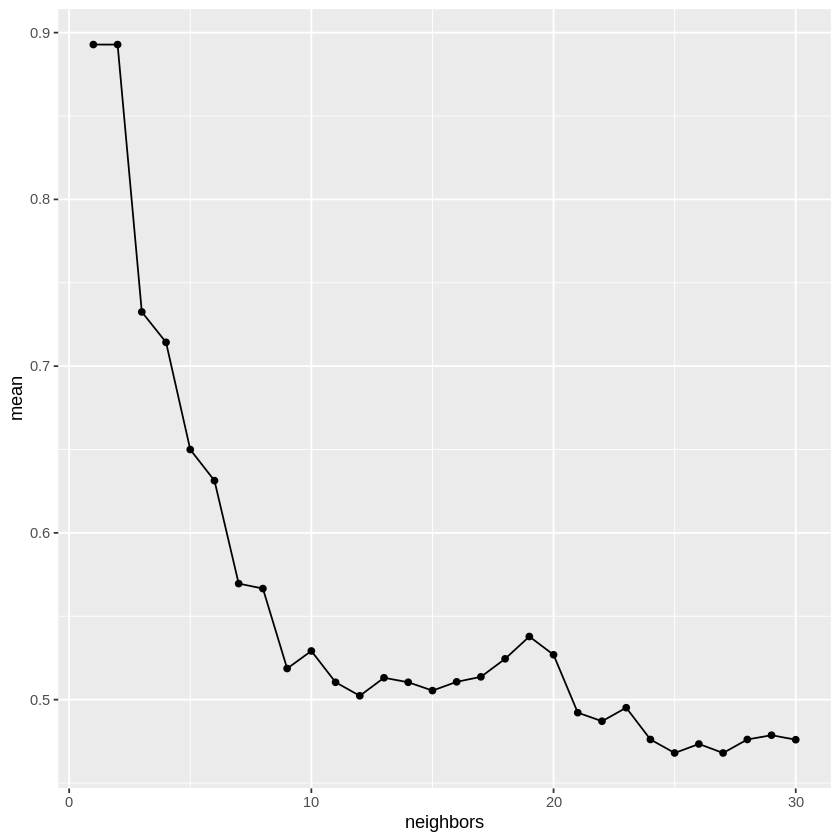

In [42]:
# Model 1.4 - Air Pressure + Humidity + Visibility + Temp
temp4_recipe <- recipe(Weather ~ Press + Humid + Vis + Temp, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

temp4_fit <- workflow() %>%
    add_recipe(temp4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

temp4_accuracy <- temp4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
temp4_accuracy

temp4_accuracy_plot <- temp4_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
temp4_accuracy_plot

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8689536,5,0.009932782,Preprocessor1_Model01
2,accuracy,multiclass,0.8689536,5,0.009932782,Preprocessor1_Model02
3,accuracy,multiclass,0.7565489,5,0.026661530,Preprocessor1_Model03
4,accuracy,multiclass,0.7352044,5,0.027234222,Preprocessor1_Model04
5,accuracy,multiclass,0.6496881,5,0.015442802,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
25,accuracy,multiclass,0.5108108,5,0.011624764,Preprocessor1_Model25
29,accuracy,multiclass,0.5081081,5,0.006890567,Preprocessor1_Model29
24,accuracy,multiclass,0.5079695,5,0.009145903,Preprocessor1_Model24


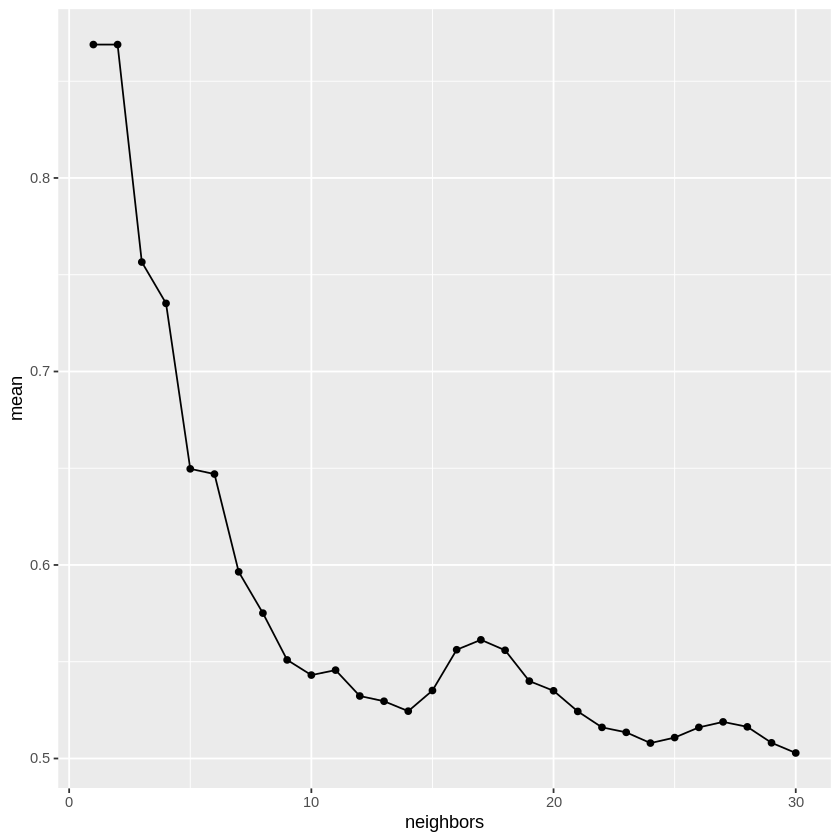

In [43]:
# Model 2.4 - Air Pressure + Humidity + Visibility + Wind Speed
wind4_recipe <- recipe(Weather ~ Press + Humid + Vis + Wind_Spd, data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wind4_fit <- workflow() %>%
    add_recipe(wind4_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

wind4_accuracy <- wind4_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
wind4_accuracy

wind4_accuracy_plot <- wind4_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
wind4_accuracy_plot

**Findings:** Using air Pressure, humidity, visibility and temperature has the highest in phase 4, but is not more accurate than the previous.

#### Phase 5: All variables

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8847540,5,0.01611789,Preprocessor1_Model01
2,accuracy,multiclass,0.8847540,5,0.01611789,Preprocessor1_Model02
3,accuracy,multiclass,0.7602218,5,0.02552699,Preprocessor1_Model03
4,accuracy,multiclass,0.7226611,5,0.02947751,Preprocessor1_Model04
5,accuracy,multiclass,0.6441441,5,0.01661179,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,accuracy,multiclass,0.4573112,5,0.02147447,Preprocessor1_Model27
23,accuracy,multiclass,0.4547471,5,0.02188023,Preprocessor1_Model23
25,accuracy,multiclass,0.4519058,5,0.02028593,Preprocessor1_Model25


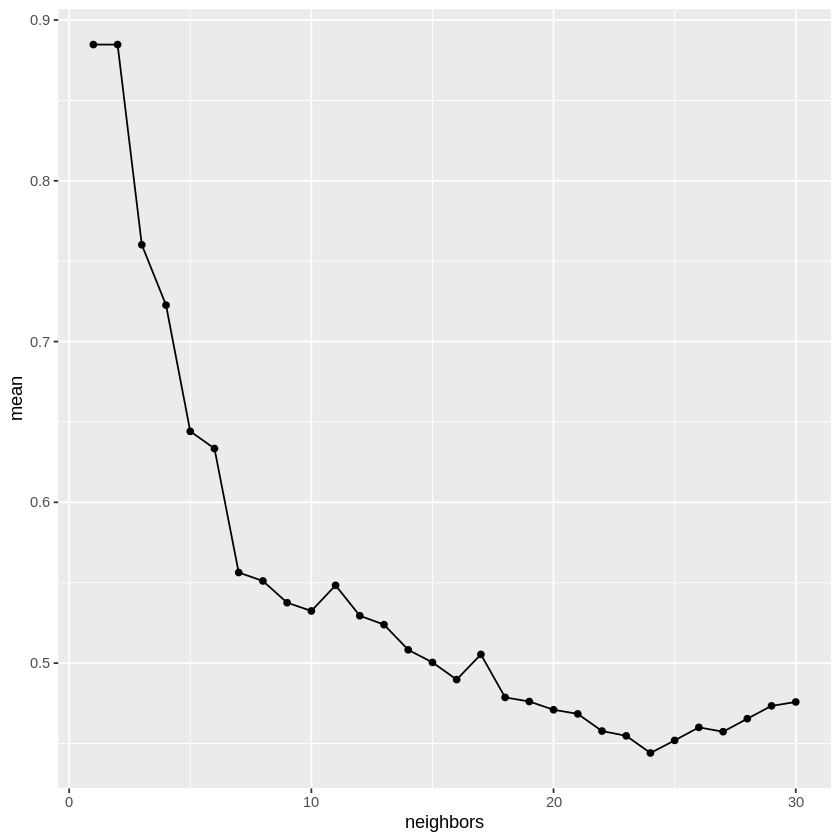

In [44]:
# Model 1.5 - Air Pressure + Humidity + Visibility + Wind Speed + Temperature
all_recipe <- recipe(Weather ~ ., data = upsampled_weather) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

all_fit <- workflow() %>%
    add_recipe(all_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

all_accuracy <- all_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
all_accuracy

all_accuracy_plot <- all_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line()
all_accuracy_plot

**Findings:** Using all predictor variables is still slightly less accurate than using the 3 variables identified in phase 3. Thus we will be using *air pressure*, *humidity*, and *visibility* as predictors in our final model. 

In [6]:
set.seed(2022) #we need this to make our code reproducible because cross validation is a random process

#make final recipe with cross validation to find k

weather_recipe <- recipe(Weather ~ Press + Humid + Vis, data = weather_train) %>% 
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

weather_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_knn) %>%
    tune_grid(resamples = weather_vfold, grid = k_grid) %>%
    collect_metrics()

#find accuracy for different values of k on our model

weather_accuracy <- weather_fit %>%
    filter(.metric == "accuracy") %>%
    arrange(-mean)
weather_accuracy


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8686732,5,0.02700415,Preprocessor1_Model01
2,accuracy,multiclass,0.8685679,5,0.02783658,Preprocessor1_Model02
3,accuracy,multiclass,0.7192917,5,0.02598225,Preprocessor1_Model03
4,accuracy,multiclass,0.6900865,5,0.03388124,Preprocessor1_Model04
5,accuracy,multiclass,0.6203378,5,0.04942068,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
17,accuracy,multiclass,0.4785785,5,0.02069278,Preprocessor1_Model17
18,accuracy,multiclass,0.4759108,5,0.01656630,Preprocessor1_Model18
20,accuracy,multiclass,0.4757325,5,0.01948991,Preprocessor1_Model20


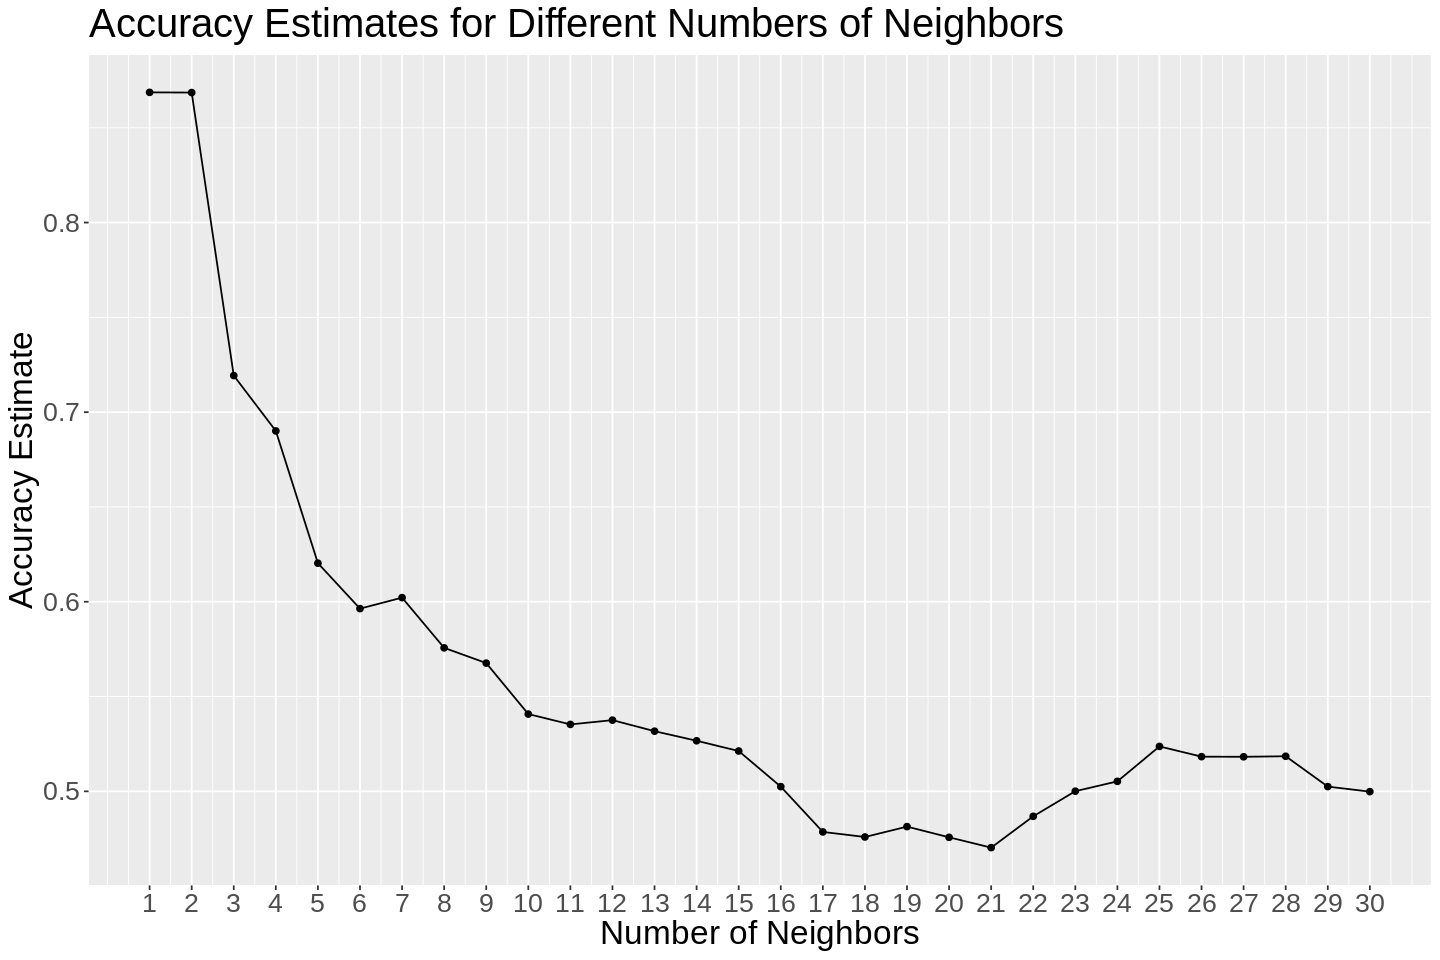

In [7]:
#create line plot with data points for accuracy estimate vs neighbors to find optimal k value
#(looking for high accuracy estimate with high values of accuracy for nearby values of k as well)

options(repr.plot.height = 8, repr.plot.width = 12)
finding_k_plot <- ggplot(weather_accuracy, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy Estimate",
        title = "Accuracy Estimates for Different Numbers of Neighbors") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 1:30)
finding_k_plot

In [20]:
#retrain our model with the newfound value of k and fit it to our training data

#since k = 2 has the highest accuracy, we will use that in our new model

weather_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>% 
    set_engine("kknn") %>%
    set_mode("classification")

weather_fit_final <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(weather_model) %>%
    fit(data = weather_train)

In [21]:
#we can now use our fitted model to predict the weather for our testing data set

weather_predictions <- predict(weather_fit_final, weather_test) %>%
    bind_cols(weather_test) %>%
    select(.pred_class, Weather)
weather_predictions

.pred_class,Weather
<fct>,<fct>
Mostly Cloudy,Mostly Cloudy
Rain,Rain
Cloudy,Cloudy
Mainly Clear,Mainly Clear
Mostly Cloudy,Mostly Cloudy
⋮,⋮
Mostly Cloudy,Rain Showers
Rain,Rain
Rain,Rain


In [22]:
#we can use the metrics function to see how accurate our model was at predicting weather values 
#on the testing dataset

weather_metrics <- weather_predictions %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
weather_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8730159


In [115]:
set.seed(2022)

weather_test_mostly_cloudy <- weather_test %>% filter(Weather == "Mostly Cloudy") 

mostly_cloudy_prediction <- predict(weather_fit_final, weather_test_mostly_cloudy) %>%
    bind_cols(weather_test_mostly_cloudy) %>%
    select(.pred_class, Weather) %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    mutate(Weather = c("Mostly Cloudy")) %>%
    select(Weather, .estimate)

weather_test_cloudy <- weather_test %>% filter(Weather == "Cloudy") 

cloudy_prediction <- predict(weather_fit_final, weather_test_cloudy) %>%
    bind_cols(weather_test_cloudy) %>%
    select(.pred_class, Weather) %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    mutate(Weather = c("Cloudy")) %>%
    select(Weather, .estimate)

weather_test_rain_showers <- weather_test %>% filter(Weather == "Rain Showers") 

rain_showers_prediction <- predict(weather_fit_final, weather_test_rain_showers) %>%
    bind_cols(weather_test_rain_showers) %>%
    select(.pred_class, Weather) %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    mutate(Weather = c("Rain Showers")) %>%
    select(Weather, .estimate)

weather_test_rain <- weather_test %>% filter(Weather == "Rain") 

rain_prediction <- predict(weather_fit_final, weather_test_rain) %>%
    bind_cols(weather_test_rain) %>%
    select(.pred_class, Weather) %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    mutate(Weather = c("Rain")) %>%
    select(Weather, .estimate)

weather_test_mainly_clear <- weather_test %>% filter(Weather == "Mainly Clear") 

mainly_clear_prediction <- predict(weather_fit_final, weather_test_mainly_clear) %>%
    bind_cols(weather_test_mainly_clear) %>%
    select(.pred_class, Weather) %>%
    metrics(truth = Weather, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    mutate(Weather = c("Mainly Clear")) %>%
    select(Weather, .estimate)

weather_accuracies <- mostly_cloudy_prediction %>% bind_rows(cloudy_prediction, 
                                                                 rain_showers_prediction, 
                                                                 rain_prediction,
                                                                 mainly_clear_prediction)
weather_accuracies

Weather,.estimate
<chr>,<dbl>
Mostly Cloudy,0.8378378
Cloudy,0.9629630
Rain Showers,0.9090909
Rain,0.8000000
Mainly Clear,0.9375000


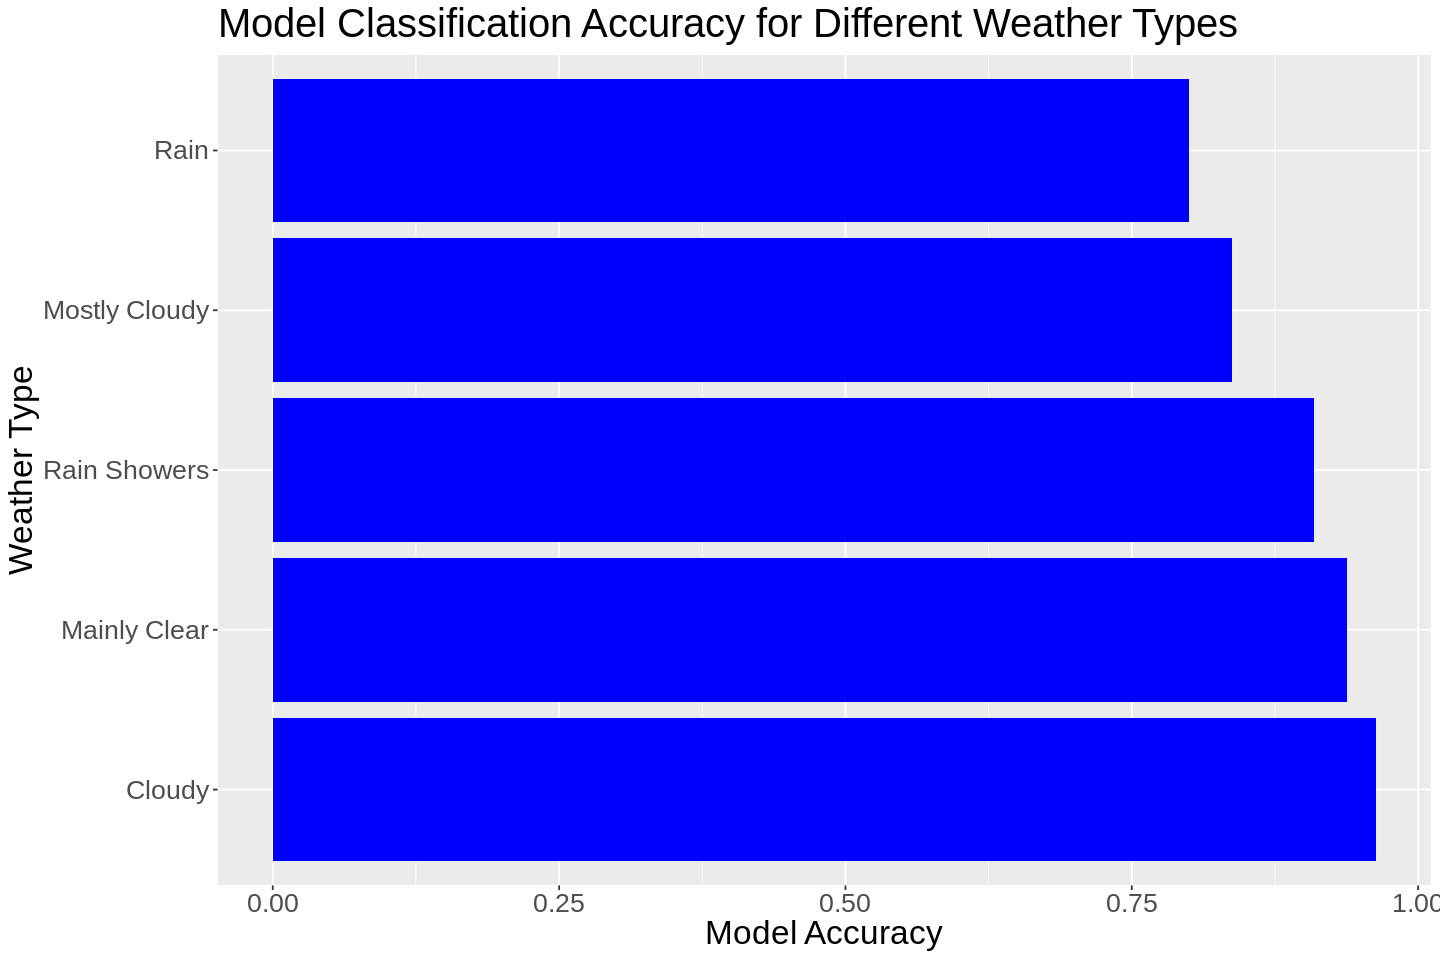

In [116]:
weather_plot <- weather_accuracies %>%
    ggplot(aes(x = fct_reorder(Weather, .estimate, .desc = TRUE), y = .estimate)) + 
    geom_bar(stat = "identity", fill = "blue") + 
    labs(x = "Weather Type", y = "Model Accuracy") + 
    theme(text = element_text(size = 20)) + 
    ggtitle("Model Classification Accuracy for Different Weather Types") + 
    coord_flip()

weather_plot

In [60]:
cloudy_count <- nrow(weather_test_cloudy)

cloudy_estimates <- predict(weather_fit_final, weather_test_cloudy) %>%
    bind_cols(weather_test_cloudy) %>% 
    group_by(.pred_class) %>%
    count() %>%
    mutate(prct_guessed = n/cloudy_count) %>%
    select(-n)
    
cloudy_estimates

rain_count <- nrow(weather_test_rain)

rain_estimates <- predict(weather_fit_final, weather_test_rain) %>%
    bind_cols(weather_test_rain) %>% 
    group_by(.pred_class) %>%
    count() %>%
    mutate(prct_guessed = n/rain_count) %>%
    select(-n)
rain_estimates

.pred_class,prct_guessed
<fct>,<dbl>
Cloudy,0.96296296
Rain Showers,0.03703704


.pred_class,prct_guessed
<fct>,<dbl>
Mostly Cloudy,0.05714286
Cloudy,0.11428571
Rain Showers,0.02857143
Rain,0.80000000
